<a href="https://colab.research.google.com/github/estmon98/bannksAnalysis/blob/main/Second_Banks_Analysis_Fiserv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Banks Analysis Project**

by: Esteban Montoya

## **Part 1:** Data extraction process explained

**Step 1:** Reading initial data: List of 1813 Banks with their respective FDIC cert and Bank Name as main information needed for the analysis

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
import requests
import pandas as pd
import os

# Load the Excel file
file_path = '/content/drive/MyDrive/Banks data/banks_classify.xlsx'
banks_df = pd.read_excel(file_path,sheet_name="Sheet1")

banks_df

,FDIC Cert.,Bank Name,State,Total Assets,Unnamed: 4,Total Assets (millions),App Screenshot,Finally not found
0,30367,1ST BANK OF SEA ISLE CITY,NJ,313000000,313.0,313.0,30367,30367
1,57298,1ST BANK YUMA,AZ,584400000,584.4,584.4,57298,57298
2,58485,1ST CAPITAL BANK,CA,960400000,960.4,960.4,58485,58485
3,1673,1ST FINANCIAL BANK USA,SD,1116100000,1116.1,1116.1,1673,1673
4,57626,1ST STATE BANK,MI,479400000,479.4,479.4,57626,57626
...,...,...,...,...,...,...,...,...
1808,18031,WOODSVILLE GUARANTY SAVINGS BANK,NH,686900000,686.9,686.9,Image not found,18031
1809,5335,WOODTRUST BANK,WI,630100000,630.1,630.1,Image not found,5335
1810,57414,WORTHINGTON BANK,TX,510200000,510.2,510.2,Image not found,57414
1811,28116,YAKIMA FEDERAL SAVINGS AND LOAN ASSOCIATION,WA,1984600000,1984.6,1984.6,Image not found,28116


**Step 2:** Data extraction with Apple search API to get apple app screenshot for each bank of the list and download all images into a folder with the bank's name.

First limitation: 1625/1812 coincidence of url for getting screenshots. (Could be improved)

In [ ]:
# @title
def search_app_store(bank_name):
    base_url = "https://itunes.apple.com/search"
    params = {
        "term": bank_name,
        "entity": "software",
        "country": "us"
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

def download_screenshots(screenshot_urls, download_folder):
    # Ensure the directory exists
    os.makedirs(download_folder, exist_ok=True)

    for idx, url in enumerate(screenshot_urls):
        response = requests.get(url)
        if response.status_code == 200:
            file_path = f"{download_folder}/screenshot_{idx+1}.jpg"
            with open(file_path, "wb") as file:
                file.write(response.content)

In [ ]:
# @title
bank_names = banks_df['Bank Name'].tolist()
for bank_name in bank_names:  # Assume `bank_names` is a list of the names of the banks
    result = search_app_store(bank_name)
    if result and result['resultCount'] > 0:
        # Assuming you're interested in the first result
        app_info = result['results'][0]
        screenshot_urls = app_info.get('screenshotUrls', [])
        download_folder = f"/content/drive/MyDrive/Banks data/screenshots/{bank_name}"  # You might need to create this directory if it doesn't exist
        download_screenshots(screenshot_urls, download_folder)

**Step 3:** Manually selected data to train the model creating two folders:
1. Images of Fiserv products.
2. Images of Non-Fiserv products.

see https://drive.google.com/drive/folders/1HEUAx051rzqndgE_oBJkaY1ZtIr-EzVx?usp=sharing


In [ ]:
# @title
!pip install torch
!pip install torch torchvision -U
!pip install cohere
!pip install tiktoken
!pip install transformers

**Step 4:** Downloaded a pre trained ResNet-18 model (Convolutional neural network) and imported Pytorch library.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [ ]:
# @title
import torch
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the classifier to fit our binary classification task
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # '2' for Fiserv and Non-Fiserv

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.7MB/s]


**Step 5:** Loaded the training dataset and splitted into train and test. Then trained the model.





In [ ]:
# @title
import requests
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Path to your dataset
data_dir = '/content/drive/MyDrive/Banks data/Training Model Data'

# Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# @title
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10  # You can adjust this

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

print('Finished Training')

Epoch 1, Loss: 0.404158566147089
Epoch 2, Loss: 0.19821274327114224
Epoch 3, Loss: 0.10534081421792507
Epoch 4, Loss: 0.04137509767897427
Epoch 5, Loss: 0.026225418830290437
Epoch 6, Loss: 0.006551314564421773
Epoch 7, Loss: 0.0025264303898438812
Epoch 8, Loss: 0.003769019152969122
Epoch 9, Loss: 0.0027432262839283796
Epoch 10, Loss: 0.0009068122715689241
Finished Training


**Step 6:** After Fine tunning the model got an accuracy of 94.87%

In [ ]:
# @title
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on test images: {100 * correct / total}%')


**Step 7:** Used the model with all the bank app screenshots to get a classification for each bank with "Uses Fiserv" and "Does Not Use Fiserv"

In [ ]:
# @title
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/MyDrive/Banks data/entire_model2.pth',map_location ='cpu')
#model = net.load_state_dict(torch.load('/content/drive/MyDrive/Banks data/entire_model2.pth', map_location=torch.device('cpu')))
model.eval()

model.to(device)

In [ ]:
# @title
import os
import torch
from torchvision import transforms
from PIL import Image
from collections import defaultdict


# Assuming model and device setup as before
model.eval()  # Ensure model is in evaluation mode
# Assuming 'device' is defined as below and used throughout your code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict a single image
def predict_image(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move the image tensor to the same device as the model
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Directory containing all the bank folders
dataset_path = '/content/drive/MyDrive/Banks data/screenshots'

# Initialize a dictionary to store the final classification of each bank
bank_classification = {}

for bank_name in os.listdir(dataset_path):
    bank_folder = os.path.join(dataset_path, bank_name)
    if os.path.isdir(bank_folder):
        predictions = []  # Store predictions for each image in the bank's folder
        for image_name in os.listdir(bank_folder):
            image_path = os.path.join(bank_folder, image_name)
            if os.path.isfile(image_path):
                prediction = predict_image(image_path, model, device)
                predictions.append(prediction)

        # Determine the bank's classification based on the predictions
        # Example: if more than 50% of the images are classified as using Fiserv
        fiserv_images = predictions.count(1)  # Assuming '1' denotes 'Uses Fiserv'
        total_images = len(predictions)
        if fiserv_images / total_images > 0.5:  # Threshold, adjust as needed
            bank_classification[bank_name] = 'Does Not Use Fiserv'
        else:
            bank_classification[bank_name] = 'Uses Fiserv'

# Print or process the bank_classification dictionary as needed
print(bank_classification)

{'CITIZENS BANK': 'Does Not Use Fiserv', 'CASEY STATE BANK': 'Does Not Use Fiserv', 'FIRST PACIFIC BANK': 'Does Not Use Fiserv', 'HEARTLAND NATIONAL BANK': 'Does Not Use Fiserv', 'COTTONPORT BANK': 'Does Not Use Fiserv', 'FIRST INDEPENDENCE BANK': 'Does Not Use Fiserv', 'MIDSOUTH BANK': 'Does Not Use Fiserv', 'BANKFIRST': 'Does Not Use Fiserv', 'FARMERS AND MERCHANTS BANK OF SOUTH CAROLINA': 'Does Not Use Fiserv', 'MAIN STREET BANK': 'Does Not Use Fiserv', 'HEBRON SAVINGS BANK': 'Does Not Use Fiserv', 'MEREDITH VILLAGE SAVINGS BANK': 'Does Not Use Fiserv', 'HOMEBANK': 'Does Not Use Fiserv', 'MAINSTREET BANK': 'Does Not Use Fiserv', 'CAPE ANN SAVINGS BANK': 'Does Not Use Fiserv', 'FLAGLER BANK': 'Does Not Use Fiserv', 'MORRIS BANK': 'Does Not Use Fiserv', 'F & M BANK': 'Does Not Use Fiserv', 'APEX BANK': 'Does Not Use Fiserv', 'LEGEND BANK, N.A.': 'Does Not Use Fiserv', 'EARLHAM SAVINGS BANK': 'Does Not Use Fiserv', 'BANK3': 'Does Not Use Fiserv', 'FNCB BANK': 'Does Not Use Fiserv', 'BA

In [ ]:
# @title
import pandas as pd
df = pd.DataFrame(list(bank_classification.items()), columns=['Bank Name', 'Uses Fiserv'])
df

,Bank Name,Uses Fiserv
0,CITIZENS BANK,Does Not Use Fiserv
1,CASEY STATE BANK,Does Not Use Fiserv
2,FIRST PACIFIC BANK,Does Not Use Fiserv
3,HEARTLAND NATIONAL BANK,Does Not Use Fiserv
4,COTTONPORT BANK,Does Not Use Fiserv
...,...,...
1458,COREFIRST BANK & TRUST,Does Not Use Fiserv
1459,LEGACY BANK,Does Not Use Fiserv
1460,GREEN BELT BANK & TRUST,Does Not Use Fiserv
1461,HYPERION BANK,Does Not Use Fiserv


In [ ]:
# @title
!pip install xlsxwriter

In [ ]:
# @title
df.to_excel('output1.xlsx', engine='xlsxwriter')

In [ ]:
# @title
classification_Cert = df.merge(banks_df, left_on='Bank Name', right_on='Bank Name',how='left')
classification_Cert.to_excel('output2.xlsx', engine='xlsxwriter')

In [ ]:
classification_Cert

,Bank Name,Uses Fiserv,FDIC Cert.,State,App Screenshot
0,CITIZENS BANK,Does Not Use Fiserv,14488,MO,14488
1,CITIZENS BANK,Does Not Use Fiserv,324,MS,Image not found
2,CITIZENS BANK,Does Not Use Fiserv,16817,TX,Image not found
3,CITIZENS BANK,Does Not Use Fiserv,9647,IN,Image not found
4,CITIZENS BANK,Does Not Use Fiserv,893,TN,Image not found
...,...,...,...,...,...
1620,LEGACY BANK,Does Not Use Fiserv,4042,OK,Image not found
1621,LEGACY BANK,Does Not Use Fiserv,17676,KS,Image not found
1622,GREEN BELT BANK & TRUST,Does Not Use Fiserv,26760,IA,26760
1623,HYPERION BANK,Does Not Use Fiserv,58371,PA,58371


**Step 8:** Added the FDIC cert with a merged between the initial data and the bank classification result.

In [ ]:
# @title
excel_path = '/content/drive/MyDrive/Banks data/classification_complete.xlsx'

**Step 9:** Used FDIC financial API to get financial information for all banks previusly classified, filtering since 2022-01-01, to get the information by quarter since that date.

see: https://banks.data.fdic.gov/docs/#/



In [ ]:
# @title
import pandas as pd
import requests

# Initialize an empty DataFrame to store the extracted data
columns = ['CERT', 'Report Date', 'Assets', 'Deposits', 'ROA', 'ZIP', 'State Name', 'Risk Date', 'ROE', 'Bank Name','Net income','NET INCOME - RATIO','NETINCQ - Net income - quarterly','NETINCQA - Net income - quarterly','NET INCOME - QUARTERLY RATIO']
extracted_data = pd.DataFrame(columns=columns)

# Loop through the DataFrame to get FDIC certificate numbers
for cert_number in classification_Cert['FDIC Cert.']:
    response = requests.get(f'https://banks.data.fdic.gov/api/financials?filters=CERT%3A%20{cert_number}%20AND%20REPDTE%3A%5B%222022-01-01%22%20TO%20%222024-12-31%22%5D%20&fields=CERT%2CREPDTE%2CASSET%2CDEP%2CROA%2CZIP%2CSTNAME%2CRISDATE%2CROE%2CNAME%2CCITY%2CNETINC%2CNETINCR%2CNETINCQ%2CNETINCQA%2CNETINCQR&sort_by=REPDTE&sort_order=DESC&limit=500&format=json&download=false&filename=data_file')

    if response.status_code == 200:
        response_data = response.json().get('data', [])
        for item in response_data:
            bank_data = item['data']  # Access the nested 'data' dictionary
            # Extract and organize the data
            row = {
                'CERT': bank_data.get('CERT', ''),
                'Report Date': bank_data.get('REPDTE', ''),
                'Assets': bank_data.get('ASSET', ''),
                'Deposits': bank_data.get('DEP', ''),
                'ROA': bank_data.get('ROA', ''),
                'ZIP':bank_data.get('ZIP', ''),  # Adjust according to actual response if ZIP is available
                'State Name':bank_data.get('STNAME', ''),  # Adjust according to actual response if STNAME is available
                'City':bank_data.get('CITY', ''),  # Adjust according to actual response if RISDATE is available
                'ROE': bank_data.get('ROE', ''),
                'Bank Name': bank_data.get('NAME', ''),
                'Net income': bank_data.get('NETINC', ''),
                'NET INCOME - RATIO': bank_data.get('NETINCR', ''),
                'NETINCQ - Net income - quarterly': bank_data.get('NETINCQ', ''),
                'NETINCQA - Net income - quarterly': bank_data.get('NETINCQA', ''),
                'NET INCOME - QUARTERLY RATIO': bank_data.get('NETINCQR', '')
            }
            extracted_data = extracted_data.append(row, ignore_index=True)
    else:
        print(f"Failed to fetch data for certificate number: {cert_number}. Response status: {response.status_code}")



#print(f"Data extraction complete. Saved to '{output_excel_path}'.")

In [ ]:
# @title
extracted_data.to_excel('output3.xlsx', engine='xlsxwriter')

**Step 10:** Merged the banks classified by the image with the FDIC financial data.



In [ ]:
# @title
merged = extracted_data.merge(classification_Cert, left_on='CERT', right_on='FDIC Cert.',how='left')
merged

,CERT,Report Date,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,Bank Name_x,...,City,Bank Name_y,Uses Fiserv,FDIC Cert.,State,Total Assets,Unnamed: 4,Total Assets (millions),App Screenshot,Finally not found
0,14488,20230930,320255,278550,1.137327,63068,MISSOURI,NaN,9.54,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
1,14488,20230630,312663,267202,1.155274,63068,MISSOURI,NaN,9.69,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
2,14488,20230331,303420,258094,1.122569,63068,MISSOURI,NaN,9.42,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
3,14488,20221231,301621,256380,1.158485,63068,MISSOURI,NaN,9.65,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
4,14488,20220930,279329,235033,1.152535,63068,MISSOURI,NaN,9.56,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11367,12788,20230331,503941,444904,1.099203,53913,WISCONSIN,NaN,11.39,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788
11368,12788,20221231,517890,459899,0.751082,53913,WISCONSIN,NaN,8.15,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788
11369,12788,20220930,523883,467356,0.884579,53913,WISCONSIN,NaN,9.64,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788
11370,12788,20220630,511349,455315,0.871377,53913,WISCONSIN,NaN,9.44,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788


In [ ]:
df = merged
df

,CERT,Report Date,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,Bank Name_x,...,NET INCOME - RATIO,NETINCQ - Net income - quarterly,NETINCQA - Net income - quarterly,NET INCOME - QUARTERLY RATIO,City,Bank Name_y,Uses Fiserv,FDIC Cert.,State,App Screenshot
0,14488,20230930,320255,278550,1.137327,63068,MISSOURI,NaN,9.54,CITIZENS BANK,...,1.137072,873,3492,1.103460,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,14488
1,14488,20230630,312663,267202,1.155274,63068,MISSOURI,NaN,9.69,CITIZENS BANK,...,1.155274,918,3672,1.192047,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,14488
2,14488,20230331,303420,258094,1.122569,63068,MISSOURI,NaN,9.42,CITIZENS BANK,...,1.122569,849,3396,1.122569,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,14488
3,14488,20221231,301621,256380,1.158485,63068,MISSOURI,NaN,9.65,CITIZENS BANK,...,1.158485,872,3488,1.200792,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,14488
4,14488,20220930,279329,235033,1.152535,63068,MISSOURI,NaN,9.56,CITIZENS BANK,...,1.152275,841,3364,1.211355,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,14488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11367,12788,20230331,503941,444904,1.099203,53913,WISCONSIN,NaN,11.39,BARABOO STATE BANK,...,1.099203,1404,5616,1.099203,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,12788
11368,12788,20221231,517890,459899,0.751082,53913,WISCONSIN,NaN,8.15,BARABOO STATE BANK,...,0.751082,451,1804,0.346333,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,12788
11369,12788,20220930,523883,467356,0.884579,53913,WISCONSIN,NaN,9.64,BARABOO STATE BANK,...,0.884380,1192,4768,0.921146,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,12788
11370,12788,20220630,511349,455315,0.871377,53913,WISCONSIN,NaN,9.44,BARABOO STATE BANK,...,0.871377,832,3328,0.643391,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,12788


## **Part 2:** Data Analysis

**Step 1:**  Read the data to analyze.

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title
import pandas as pd
excel_path = '/content/drive/MyDrive/Banks data/output4.xlsx'  # Update this with the path to your Excel file
df = pd.read_excel(excel_path, sheet_name='Sheet1')

In [ ]:
df

,CERT,Report Date,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,Bank Name_x,...,City,Bank Name_y,Uses Fiserv,FDIC Cert.,State,Total Assets,Unnamed: 4,Total Assets (millions),App Screenshot,Finally not found
0,14488,20230930,320255,278550,1.137327,63068,MISSOURI,NaN,9.54,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
1,14488,20230630,312663,267202,1.155274,63068,MISSOURI,NaN,9.69,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
2,14488,20230331,303420,258094,1.122569,63068,MISSOURI,NaN,9.42,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
3,14488,20221231,301621,256380,1.158485,63068,MISSOURI,NaN,9.65,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
4,14488,20220930,279329,235033,1.152535,63068,MISSOURI,NaN,9.56,CITIZENS BANK,...,NEW HAVEN,CITIZENS BANK,Does Not Use Fiserv,14488,MO,312700000,312.7,312.7,14488,14488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11367,12788,20230331,503941,444904,1.099203,53913,WISCONSIN,NaN,11.39,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788
11368,12788,20221231,517890,459899,0.751082,53913,WISCONSIN,NaN,8.15,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788
11369,12788,20220930,523883,467356,0.884579,53913,WISCONSIN,NaN,9.64,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788
11370,12788,20220630,511349,455315,0.871377,53913,WISCONSIN,NaN,9.44,BARABOO STATE BANK,...,BARABOO,BARABOO STATE BANK,Does Not Use Fiserv,12788,WI,504300000,504.3,504.3,12788,12788


**Step 2:** Get the average and median for the key financial indicators for each group of banks "Does Not Uses Fiserv" and "Uses Fiserv".

In [ ]:
# @title
# Group the data by the 'Uses Fiserv' column and calculate the mean for the specified metrics
grouped_means = df.groupby('Uses Fiserv')[['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']].mean()

grouped_means

,Assets,Deposits,ROA,ROE,Net income
Uses Fiserv,,,,,
Does Not Use Fiserv,730754.306563,630823.996724,1.141079,13.231124,4682.689555
Uses Fiserv,711409.884308,611305.137105,1.042829,12.852526,4315.113774


**Results:**

Average Assets
*   Banks that do not use Fiserv: US 730,754,306
*   Banks that use Fiserv: US 711,409,884


Average Deposits
*   Banks that do not use Fiserv: US 630,823,997
*   Banks that use Fiserv: US 611,305,137

Average Return on Assets (ROA)
*   Banks that do not use Fiserv: 1.14%
*   Banks that use Fiserv: 1.04%

Average Return on Equity (ROE)
*   Banks that do not use Fiserv: 13.2%
*   Banks that use Fiserv: 12.8%

Average Net Income
*   Banks that do not use Fiserv: US 4,682,689
*   Banks that use Fiserv: US 4,315,114



In [ ]:
# @title
# Group the data by the 'Uses Fiserv' column and calculate the mean for the specified metrics
grouped_median = df.groupby('Uses Fiserv')[['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']].median()

grouped_median

,Assets,Deposits,ROA,ROE,Net income
Uses Fiserv,,,,,
Does Not Use Fiserv,582041.0,509334.0,1.068710,12.120,3272.0
Uses Fiserv,573144.0,487609.0,1.008255,11.245,3002.0


**Results:**

Median Assets
*   Banks that do not use Fiserv: US 582,041,000
*   Banks that use Fiserv: US 573,144,000


Median Deposits
*   Banks that do not use Fiserv: US 509,334,000
*   Banks that use Fiserv: US 487,609,000

Median Return on Assets (ROA)
*   Banks that do not use Fiserv: 1.069%
*   Banks that use Fiserv: 1.008%

Median Return on Equity (ROE)
*   Banks that do not use Fiserv: 12.1%
*   Banks that use Fiserv: 11.2%

Median Net Income
*   Banks that do not use Fiserv: US 3,272,000
*   Banks that use Fiserv: US 3,002,000



**Conclusion:**

We can already see a tendency for the banks that do not use Fiserv to have higher Financial indicators. Now we test to see if they are statiscatically significant.

**Step 3:** t-test to determine if there is a significant difference between the means of the two groups.

In [ ]:
# @title
from scipy.stats import ttest_ind
import pandas as pd

# Load the data
data = df
# Split the data into two groups based on the 'Uses Fiserv' status
group_fiserv = data[data['Uses Fiserv'] == 'Uses Fiserv']
group_non_fiserv = data[data['Uses Fiserv'] == 'Does Not Use Fiserv']

# List of metrics to perform t-tests on
metrics = ['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']  # Assuming 'Net income' is the correct column name

# Initialize a dictionary to store t-test results
t_test_results = {}

# Perform t-tests for each metric
for metric in metrics:
    # Ensure to handle missing values with 'nan_policy' and assume unequal variances with 'equal_var'
    t_stat, p_val = ttest_ind(
        group_fiserv[metric],
        group_non_fiserv[metric],
        equal_var=False,
        nan_policy='omit'
    )
    # Store the results
    t_test_results[metric] = {'t_stat': t_stat, 'p_val': p_val}

# Print the t-test results
for metric, results in t_test_results.items():
    print(f"{metric}: t-statistic = {results['t_stat']:.2f}, p-value = {results['p_val']}")

Assets: t-statistic = -2.25, p-value = 0.02462760758992139
Deposits: t-statistic = -2.62, p-value = 0.008759824929894104
ROA: t-statistic = -5.98, p-value = 2.2620269650855564e-09
ROE: t-statistic = -0.75, p-value = 0.45555219996688245
Net income: t-statistic = -3.63, p-value = 0.0002828996514519869


In [ ]:
pd.DataFrame(t_test_results).T

,t_stat,p_val
Assets,-2.247773,2.462761e-02
Deposits,-2.622169,8.759825e-03
ROA,-5.983762,2.262027e-09
ROE,-0.746268,4.555522e-01
Net income,-3.632581,2.828997e-04


**Assets, Deposits, and ROA:**

The small p-values for Assets, Deposits, and ROA (p < 0.05) suggest that the differences in the average values of these metrics between banks that use Fiserv and those that do not are statistically significant. This could indicate a real effect of using Fiserv products on these financial metrics.

**Net Income:**

The very small p-value for Net Income further strengthens the evidence that the average net income significantly differs between the two groups, suggesting a potential impact of Fiserv products on profitability.

**ROE:**

The larger p-value for ROE (greater than 0.05) indicates that the difference in the average ROE between the two groups is not statistically significant, meaning we do not have enough evidence to suggest that Fiserv usage impacts banks' ROE in the sample studied.

**Conclusion:**

The results suggest significant differences in deposits, ROA, and net income between banks that use Fiserv products and those that do not, with banks not using Fiserv generally performing better in these metrics.

**Step 4:** Group data by quarter to create visualizations and get a better view of the metrics over time.

In [ ]:
# @title
# Extract quarter from the 'Report Date Transformation' column for grouping
df['Quarter'] = pd.to_datetime(df['Report Date']).dt.to_period('Q')

# Group the data by quarter and whether the bank uses Fiserv, then calculate means
quarterly_means = df.groupby(['Quarter', 'Uses Fiserv'])[['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']].mean().reset_index()

# Display the first few rows to verify the structure
quarterly_means.head()

**Average ROA by Quarter**

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd

# Convert 'Report Date' to datetime format
data['Report Date'] = pd.to_datetime(data['Report Date'], format='%Y%m%d') + MonthEnd(1)

# Extract year and quarter from 'Report Date'
data['Year'] = data['Report Date'].dt.year
data['Quarter'] = data['Report Date'].dt.quarter

# Create a new 'Year-Quarter' column for plotting
data['Year-Quarter'] = data['Year'].astype(str) + 'Q' + data['Quarter'].astype(str)

# Define the metrics for plotting
metrics_plot = ['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']

# Set up the plotting
fig, axs = plt.subplots(len(metrics_plot), 1, figsize=(14, 5 * len(metrics_plot)))

for i, metric in enumerate(metrics_plot):
    sns.lineplot(data=data, x='Year-Quarter', y=metric, hue='Uses Fiserv', ax=axs[i], marker='o')
    axs[i].set_title(f'Trend of {metric} by Quarter')
    axs[i].set_xlabel('Year-Quarter')
    axs[i].set_ylabel(metric)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

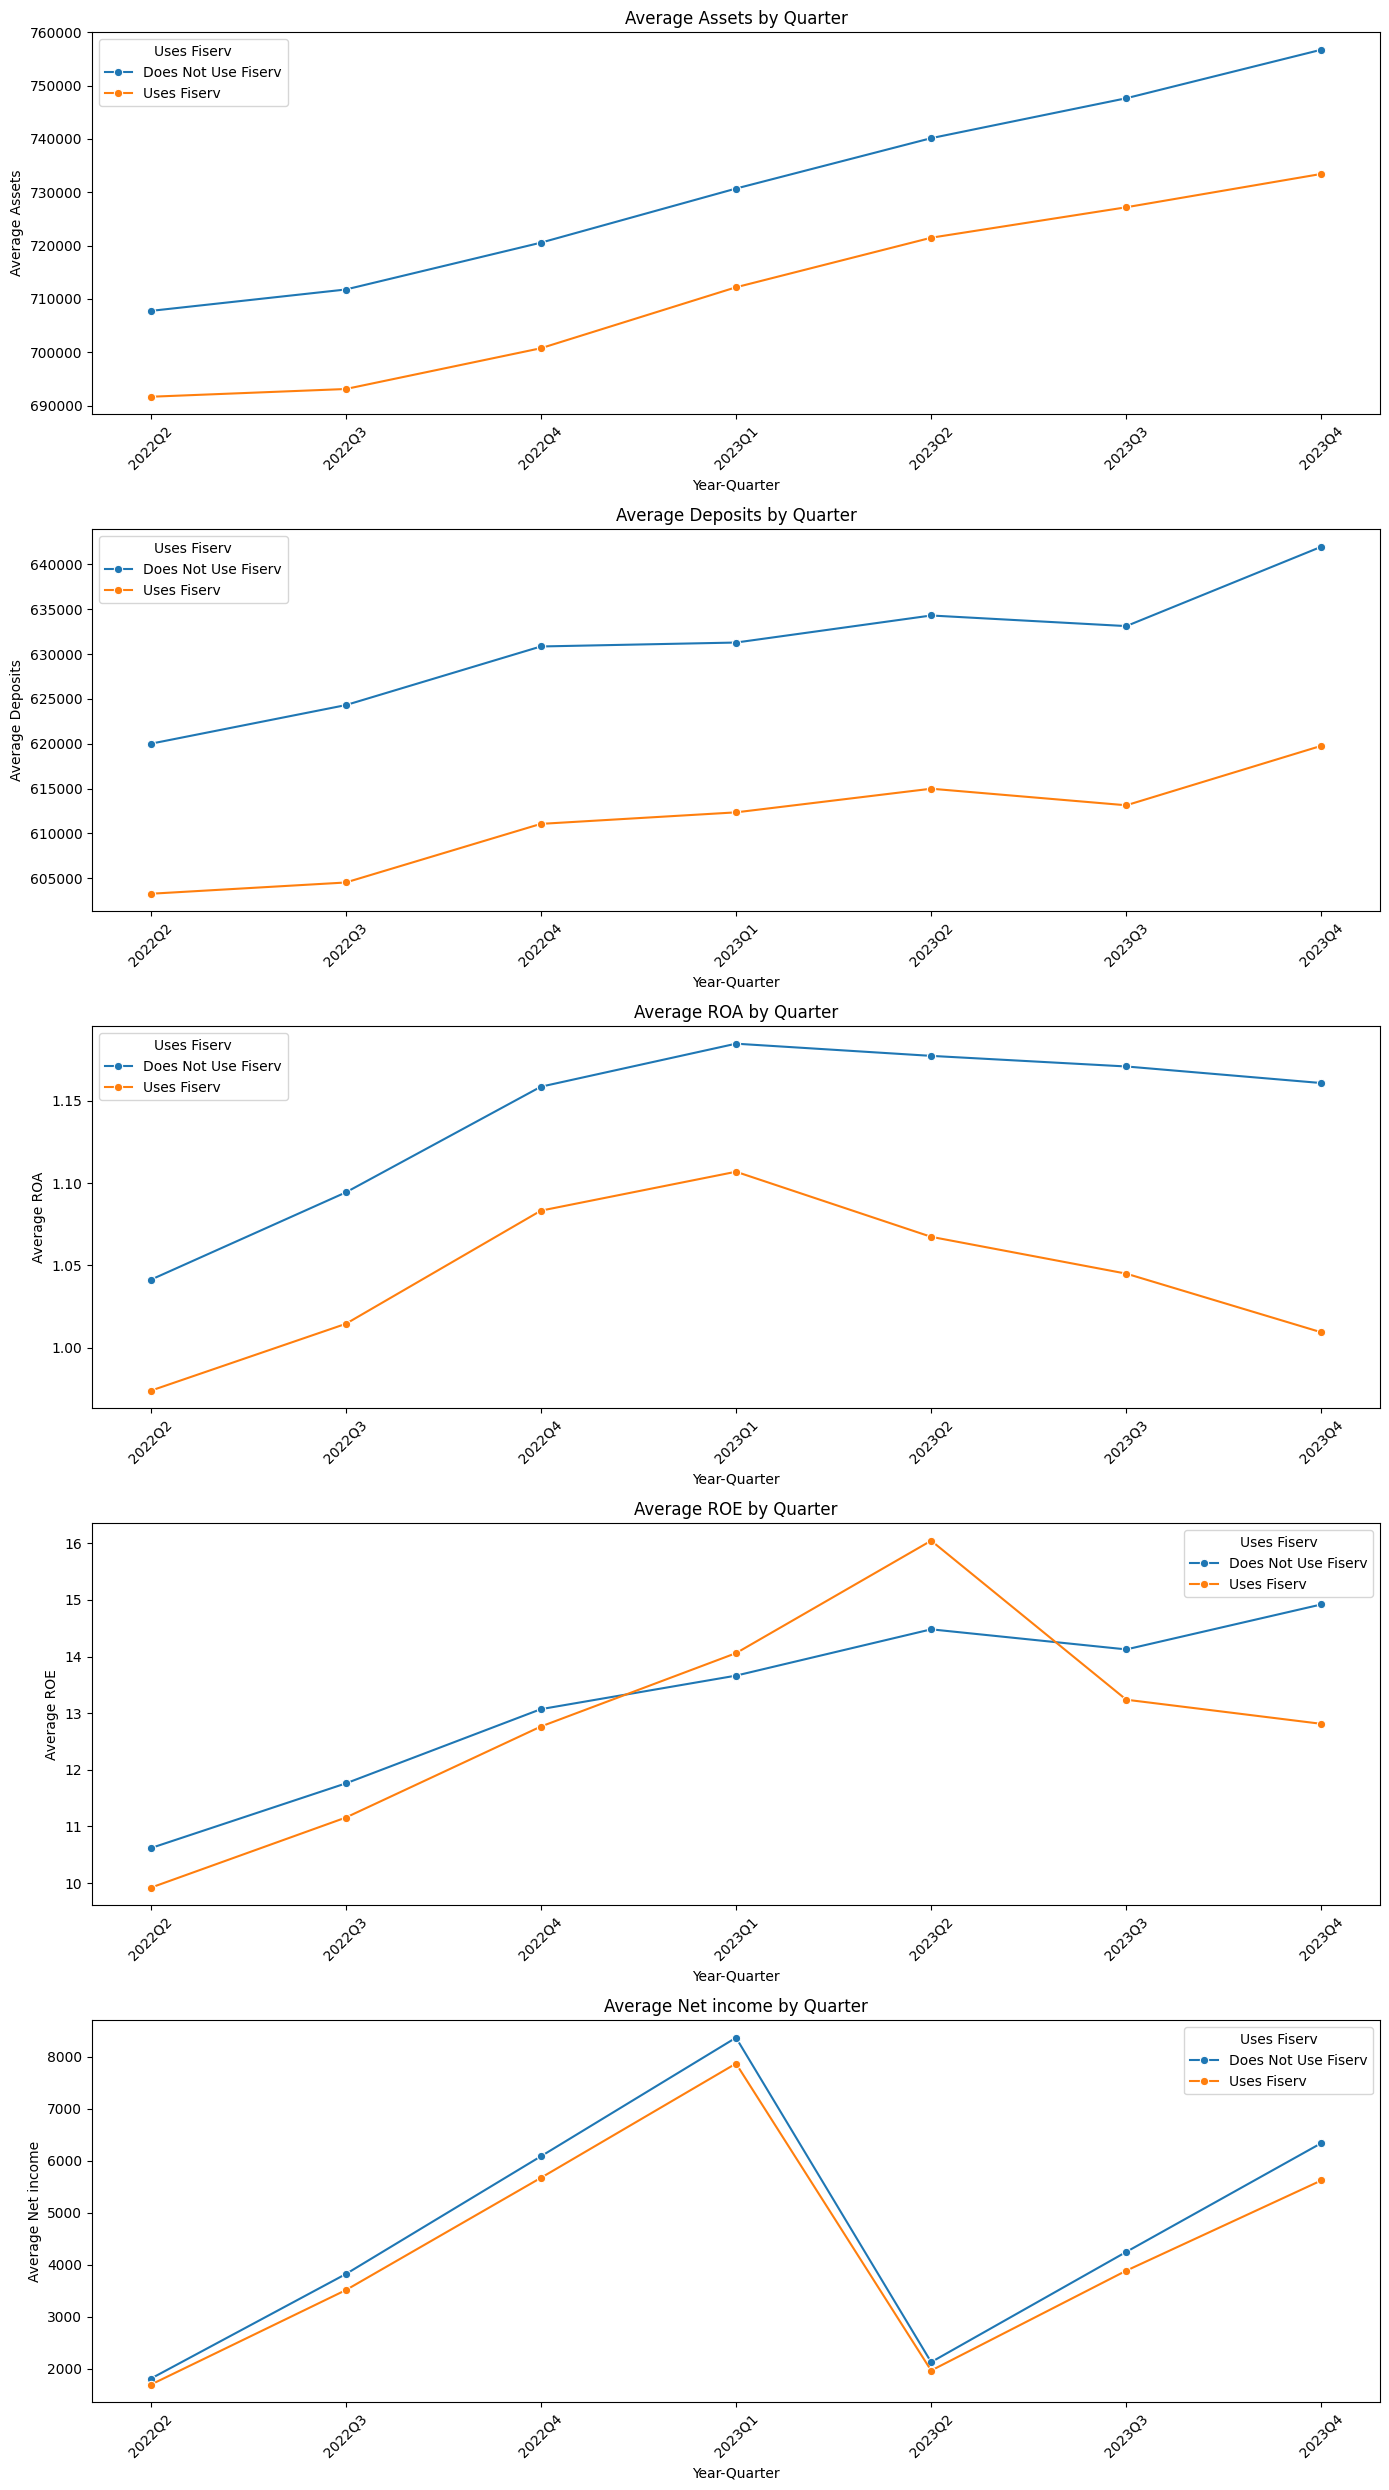

In [ ]:
# @title
# Calculate the average of each financial metric by quarter for each group
avg_metrics_by_quarter = data.groupby(['Year-Quarter', 'Uses Fiserv'])[metrics_plot].mean().reset_index()

# Set up the plotting with averages
fig, axs = plt.subplots(len(metrics_plot), 1, figsize=(14, 5 * len(metrics_plot)))

for i, metric in enumerate(metrics_plot):
    sns.lineplot(data=avg_metrics_by_quarter, x='Year-Quarter', y=metric, hue='Uses Fiserv', ax=axs[i], marker='o')
    axs[i].set_title(f'Average {metric} by Quarter')
    axs[i].set_xlabel('Year-Quarter')
    axs[i].set_ylabel(f'Average {metric}')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Conclusion:**

With the information we got we can conclude that there is a correlation between not using Fiserv and having slightly better financial metrics taking into consideration that there are limits to the assumptions made, the extraction process and there are multiple other factors affecting this metrics.

**Return on Equity (ROE) and Net Income Trends:** While there were some quarters where the performance between the two groups diverged significantly, the trends did not consistently favor one group over the other. This could imply that the effectiveness of Fiserv products may be more about enhancing operational efficiency or customer service rather than directly leading to higher profitability or growth.